In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import cvxpy as cp

In [2]:
#Load the data from CSMAR, A share from Shanghai Security Exchange
df=pd.read_csv(r"C:\Users\txy20\Desktop\PROJECT\TRD_Mnth.csv")
df=df.dropna()
df.columns=["StockCode","TradingDate","Return"]
# df=df.loc[df["TradingDate"]<="2017-12" ]

In [3]:
#Select the representative shares
stock_list=[89,151,417,521,753,600030,600036,600348,600519,601398]
df1=df.loc[df["StockCode"].isin(stock_list) ]
# df1.set_index(df1["TradingDate"],inplace=True)
df_stock=df1.reset_index()
df_stock=df_stock.iloc[:,1:]
df_stock

,StockCode,TradingDate,Return
0,89,2010-01,-0.041278
1,89,2010-02,0.050000
2,89,2010-03,-0.027778
3,89,2010-04,-0.081633
4,89,2010-05,-0.134815
...,...,...,...
1435,601398,2021-08,0.006536
1436,601398,2021-09,0.008658
1437,601398,2021-10,0.002146
1438,601398,2021-11,-0.019272


In [4]:
#Loading the risk-free
df2=pd.read_csv(r"C:\Users\txy20\Desktop\PROJECT\TRD_Nrrate.csv")
df2["Clsdt"]=pd.to_datetime(df2["Clsdt"])
df2.set_index(df2["Clsdt"],inplace=True)
df2=df2.resample("M").mean()
df_riskfree=df2.reset_index()
df_riskfree["Clsdt"]=df_riskfree["Clsdt"].apply(lambda x: x.strftime('%Y-%m'))
# df_riskfree.set_index(df_riskfree["Clsdt"],inplace=True)
df_riskfree.columns=["TradingDate","Rf"]
df_riskfree["Rf"]=df_riskfree["Rf"]/100
df_riskfree

,TradingDate,Rf
0,2010-01,0.001856
1,2010-02,0.001856
2,2010-03,0.001856
3,2010-04,0.001856
4,2010-05,0.001856
...,...,...
139,2021-08,0.001241
140,2021-09,0.001241
141,2021-10,0.001241
142,2021-11,0.001241


In [5]:
#loading market return
df3=pd.read_csv(r"C:\Users\txy20\Desktop\PROJECT\IDX_Idxtrdmth.csv")
df_market=df3.iloc[:,1:]
df_market.columns=["TradingDate","Rm"]
# df_market.set_index(df_market["TradingDate"],inplace =True)
# df_market=df_market.iloc[:,1]
df_market

,TradingDate,Rm
0,2010-01,-0.103902
1,2010-02,0.024190
2,2010-03,0.019484
3,2010-04,-0.083166
4,2010-05,-0.095883
...,...,...
139,2021-08,-0.001156
140,2021-09,0.012646
141,2021-10,0.008710
142,2021-11,-0.015634


In [6]:
#Select time period
Year=2012
start=str(Year)+"-01"
print(start)
df_market=df_market.loc[df_market["TradingDate"]>=start]
df_riskfree=df_riskfree.loc[df_riskfree["TradingDate"]>=start]
df_stock=df_stock.loc[df_stock["TradingDate"]>=start]
df_stock

2012-01


,StockCode,TradingDate,Return
24,89,2012-01,0.053012
25,89,2012-02,0.027460
26,89,2012-03,-0.042316
27,89,2012-04,0.044186
28,89,2012-05,-0.022272
...,...,...,...
1435,601398,2021-08,0.006536
1436,601398,2021-09,0.008658
1437,601398,2021-10,0.002146
1438,601398,2021-11,-0.019272


In [7]:
df_stock_rf=df_stock.merge(df_riskfree,how="outer",on=["TradingDate"])
df_stock_rf


,StockCode,TradingDate,Return,Rf
0,89,2012-01,0.053012,0.002871
1,151,2012-01,-0.133721,0.002871
2,417,2012-01,0.012031,0.002871
3,521,2012-01,-0.022573,0.002871
4,753,2012-01,-0.119048,0.002871
...,...,...,...,...
1195,600030,2021-12,0.111064,0.001241
1196,600036,2021-12,-0.015761,0.001241
1197,600348,2021-12,0.107477,0.001241
1198,600519,2021-12,0.061753,0.001241


In [8]:
#Estimate market expectation
df_market_rf=df_market.merge(df_riskfree,how="outer",on=["TradingDate"])
df_market_rf["demean"]=df_market_rf["Rm"]-df_market_rf["Rf"]
df_market_rf['d']=df_market_rf["demean"]-np.mean(df_market_rf["demean"])
df_market_rf["loss"]=df_market_rf["d"]*df_market_rf["d"]
est_var=sum(df_market_rf["loss"])/(df_market_rf.shape[0]-1)
est_var

0.004219032117153703

In [9]:
#calculate estimated covariance w.r.t the market stock for the stocks
sr=[]
mean_stock=dict()
for id in stock_list:
    df6=df_stock_rf.loc[df_stock_rf["StockCode"].isin([id]) ]
    df7=df_market_rf.merge(df6,how="outer",on=["TradingDate","Rf"])
    m=np.mean(df7["Return"])
    mean_stock[id]=m
    df7["Demean"]=df7["Return"]-df7["Rf"]
    df7["D"]=df7["Demean"]-np.mean(df7["Demean"])
    df7["cov"]=df7["d"]*df7["D"]
    est_cov=sum(df7["cov"])/(df_market_rf.shape[0]-1)
    sr.append(est_cov)
sr

[0.00392643248563932,
 0.003531156697174238,
 0.004876180658700579,
 0.0039559366087398,
 0.004033891672066442,
 0.007409866698385934,
 0.003946483794721232,
 0.0034103371262349546,
 0.003121496093416486,
 0.0020719601093919914]

In [10]:
#Get beta
beta=[]
for i in sr:
    b=i/est_var
    beta.append(b)
beta=np.array(beta)
beta
c=np.transpose(pd.DataFrame(beta))
c.columns=stock_list
c

,89,151,417,521,753,600030,600036,600348,600519,601398
0,0.930648,0.836959,1.155758,0.937641,0.956118,1.756295,0.9354,0.808322,0.739861,0.491098


In [11]:
#get expectation of market return 
Erm=np.mean(df_market_rf["Rm"])
Erm

0.008297308333333333

In [12]:
#get the implied return
Pi=[]
for b in beta:
    rf=0.001241
    r=b*(Erm-rf)+rf
    Pi.append(r)
Pi=np.array(Pi)
Pi
c=np.transpose(pd.DataFrame(Pi))
c.columns=stock_list
c

,89,151,417,521,753,600030,600036,600348,600519,601398
0,0.007808,0.007147,0.009396,0.007857,0.007988,0.013634,0.007841,0.006945,0.006462,0.004706


In [13]:
#organize dataframe 
df_main=pd.DataFrame()
for id in stock_list:
    df8=df_stock.loc[df_stock["StockCode"].isin([id])]
    df_main[id]=df8["Return"].values
    
df_main

,89,151,417,521,753,600030,600036,600348,600519,601398
0,0.053012,-0.133721,0.012031,-0.022573,-0.119048,0.100927,0.065712,0.229908,-0.035644,0.014151
1,0.027460,0.088591,0.075524,0.154734,0.088803,0.103835,0.017391,0.063739,0.096830,0.030232
2,-0.042316,-0.110974,-0.066970,-0.104000,-0.099291,-0.017797,-0.075369,-0.132427,-0.036682,-0.022573
3,0.044186,0.120666,0.020906,0.151786,0.173228,0.121657,0.025210,0.149739,0.140130,0.009238
4,-0.022272,-0.019802,-0.089420,0.005814,-0.006711,0.059231,-0.044262,-0.034326,0.053972,-0.034325
...,...,...,...,...,...,...,...,...,...,...
115,0.035920,0.136740,0.040573,0.086262,0.084000,0.155545,0.052903,0.534787,-0.072061,0.006536
116,0.027739,-0.047388,-0.004587,-0.035294,0.014760,-0.015576,0.030433,-0.169824,0.174583,0.008658
117,0.020243,-0.014031,-0.043779,-0.033537,-0.029091,0.023734,0.069772,-0.142624,-0.002142,0.002146
118,-0.063492,0.001294,-0.002410,0.050473,0.131086,-0.081530,-0.083009,0.017110,0.057330,-0.019272


In [14]:
#Compute the covariance matrix
Sigma=np.array(df_main.cov())
Sigma
df_main.cov()

,89,151,417,521,753,600030,600036,600348,600519,601398
89,0.008804,0.004360,0.005701,0.004433,0.006562,0.005671,0.002711,0.003180,0.002791,0.001626
151,0.004360,0.021828,0.005128,0.005309,0.009297,0.006331,0.003020,0.004310,0.002313,0.002232
417,0.005701,0.005128,0.009876,0.005624,0.007092,0.008297,0.003859,0.005095,0.002920,0.002072
521,0.004433,0.005309,0.005624,0.015846,0.006641,0.005428,0.001628,0.004614,0.003387,0.000418
753,0.006562,0.009297,0.007092,0.006641,0.013795,0.003704,0.002290,0.004800,0.003032,0.001302
600030,0.005671,0.006331,0.008297,0.005428,0.003704,0.018918,0.007693,0.006737,0.004276,0.004230
600036,0.002711,0.003020,0.003859,0.001628,0.002290,0.007693,0.006700,0.002757,0.002640,0.003004
600348,0.003180,0.004310,0.005095,0.004614,0.004800,0.006737,0.002757,0.012888,0.001150,0.001709
600519,0.002791,0.002313,0.002920,0.003387,0.003032,0.004276,0.002640,0.001150,0.007719,0.001626
601398,0.001626,0.002232,0.002072,0.000418,0.001302,0.004230,0.003004,0.001709,0.001626,0.002753


In [15]:
#Construct the view measure
#Step 1 the data forms a normal distribution, In this step, we solidize the normality.
dfm=df_stock  #.loc[df_stock["TradingDate"]>="2021-01"]
dfm

,StockCode,TradingDate,Return
24,89,2012-01,0.053012
25,89,2012-02,0.027460
26,89,2012-03,-0.042316
27,89,2012-04,0.044186
28,89,2012-05,-0.022272
...,...,...,...
1435,601398,2021-08,0.006536
1436,601398,2021-09,0.008658
1437,601398,2021-10,0.002146
1438,601398,2021-11,-0.019272


In [16]:
dfk=dfm.groupby("StockCode")
mvdf=dfk.agg([np.mean,np.var,np.std,np.max,np.min])
mvdf.columns=(["mean","var","std","max","min"])
mvdf["count"]=120
mvdf

C:\Users\txy20\AppData\Local\Temp\ipykernel_15296\3848677395.py:2: FutureWarning: ['TradingDate'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  mvdf=dfk.agg([np.mean,np.var,np.std,np.max,np.min])


,mean,var,std,max,min,count
StockCode,,,,,,
89,0.009579,0.008804,0.093831,0.423804,-0.260393,120
151,0.010147,0.021828,0.147744,0.911227,-0.326923,120
417,0.000167,0.009876,0.099379,0.284926,-0.306496,120
521,0.008141,0.015846,0.125880,0.836364,-0.387789,120
753,0.009068,0.013795,0.117451,0.490291,-0.342679,120
600030,0.018046,0.018918,0.137544,0.964079,-0.266022,120
600036,0.018250,0.006700,0.081854,0.372256,-0.166759,120
600348,0.006159,0.012888,0.113526,0.534787,-0.341463,120
600519,0.026823,0.007719,0.087855,0.287150,-0.248082,120


In [17]:
dfd=dfm.loc[df_stock["TradingDate"]=="2021-12"]
dfd=dfd.set_index(dfd["StockCode"])
dfd

,StockCode,TradingDate,Return
StockCode,,,
89,89,2021-12,0.033898
151,151,2021-12,0.099483
417,417,2021-12,0.065217
521,521,2021-12,0.102102
753,753,2021-12,0.145695
600030,600030,2021-12,0.111064
600036,600036,2021-12,-0.015761
600348,600348,2021-12,0.107477
600519,600519,2021-12,0.061753


In [18]:
#Since they follow normal distribution, then (x-mu)/sigma follows N(0,1), hence $(x-mu)^2/sigma^2$ follows chi-square(1)
dfd["Ireturn"]=Pi
dfd["mean"]=mvdf["mean"]
dfd["std"]=mvdf["std"]
dfd["chi"]=(dfd["Ireturn"]-mvdf["mean"])/mvdf["std"]
dfd["chi2"]=dfd["chi"]*dfd["chi"]
dfd["mark"]=np.where(dfd["Ireturn"]>=0,1,-1)


In [19]:
#The smallest chi is to be decrease while the largest chi is to increase.
N=4          #number of views
temp=dfd
viewl=[]
Q=[]
for i in range(N):
    view="view{}".format(i+1)
    viewl.append(view)
    min_id=temp["chi"].idxmin()
    max_id=temp["chi"].idxmax()
    dfd[view]=0
    dfd.loc[min_id,view]=-1
    dfd.loc[max_id,view]=1
    temp=temp.drop([max_id,min_id])
    
    #calculate the magitude of change
    per1=abs((dfd.loc[max_id,"Ireturn"]-dfd.loc[max_id,"mean"])/(dfd.loc[max_id,"Return"]))
    per2=abs((dfd.loc[min_id,"Ireturn"]-dfd.loc[min_id,"mean"])/(dfd.loc[min_id,"Return"]))
    change=abs(per1-per2)
    Q.append(change)
dfd

,StockCode,TradingDate,Return,Ireturn,mean,std,chi,chi2,mark,view1,view2,view3,view4
StockCode,,,,,,,,,,,,,
89,89,2021-12,0.033898,0.007808,0.009579,0.093831,-0.018878,0.000356,1,0,0,0,0
151,151,2021-12,0.099483,0.007147,0.010147,0.147744,-0.020309,0.000412,1,0,0,0,0
417,417,2021-12,0.065217,0.009396,0.000167,0.099379,0.092875,0.008626,1,1,0,0,0
521,521,2021-12,0.102102,0.007857,0.008141,0.125880,-0.002254,0.000005,1,0,0,1,0
753,753,2021-12,0.145695,0.007988,0.009068,0.117451,-0.009201,0.000085,1,0,0,0,1
600030,600030,2021-12,0.111064,0.013634,0.018046,0.137544,-0.032079,0.001029,1,0,0,0,-1
600036,600036,2021-12,-0.015761,0.007841,0.018250,0.081854,-0.127157,0.016169,1,0,-1,0,0
600348,600348,2021-12,0.107477,0.006945,0.006159,0.113526,0.006919,0.000048,1,0,1,0,0
600519,600519,2021-12,0.061753,0.006462,0.026823,0.087855,-0.231756,0.053711,1,-1,0,0,0


In [20]:
#The magnitude of changing:
Q=np.transpose(np.array(Q))
Q
c=np.transpose(pd.DataFrame(Q))


In [21]:
#Get the P matrix
P=np.transpose(np.array(dfd[viewl]))
P

array([[ 0,  0,  1,  0,  0,  0,  0,  0, -1,  0],
       [ 0,  0,  0,  0,  0,  0, -1,  1,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0, -1],
       [ 0,  0,  0,  0,  1, -1,  0,  0,  0,  0]], dtype=int64)

In [22]:
#tau=0.025 Ω = τdiag(PΣP^T )
tau=0.025
Tem=tau*P@Sigma@np.transpose(P)
dia=[]
for i in range(N):
    dia.append(Tem[i][i])
Omega=np.diag(dia)
Omega

array([[0.00029384, 0.        , 0.        , 0.        ],
       [0.        , 0.00035184, 0.        , 0.        ],
       [0.        , 0.        , 0.00044405, 0.        ],
       [0.        , 0.        , 0.        , 0.00063264]])

In [23]:
#Get the expected return function
def mu_P(w):
    mup=np.linalg.inv(np.linalg.inv(tau*Sigma)+np.transpose(P)@np.linalg.inv(Omega)@P)@(np.linalg.inv(tau*Sigma)@Pi+np.transpose(P)@np.linalg.inv(Omega)@Q)
    return mup
c=np.transpose(pd.DataFrame(mu_P(1)))
c.columns=stock_list
c

,89,151,417,521,753,600030,600036,600348,600519,601398
0,0.036266,0.052184,0.078961,0.105987,0.083522,0.02814,-0.072033,0.262286,-0.048611,-0.022697


In [24]:
m=len(stock_list)
w = cp.Variable(m)
l=np.ones(m)
e=mu_P(w)@w
BE=beta@w
var = cp.quad_form(w,0.5*Sigma)
Rm=0.022423
objective = cp.Minimize(var)
constraints = [l@w ==1, w>=0,e-rf-BE*(Rm-rf)==0]
prob = cp.Problem(objective, constraints)
prob.solve()
print(prob.value)
print(w.value)
print(mu_P(w.value)@w.value)
c=[4.00505342e-02,0,0, 8.94426028e-02,1.02637204e-02,0,0,8.25006720e-02,7.24090346e-02,7.05333436e-01]
c=np.transpose(pd.DataFrame(c))
c.columns=stock_list
c

0.0011966935885358518
[ 4.00505342e-02 -2.90114984e-20 -4.31537670e-21  8.94426028e-02
  1.02637204e-02 -1.49171591e-20 -3.59304177e-20  8.25006720e-02
  7.24090346e-02  7.05333436e-01]
0.013899345602382655


,89,151,417,521,753,600030,600036,600348,600519,601398
0,0.040051,0.0,0.0,0.089443,0.010264,0.0,0.0,0.082501,0.072409,0.705333


In [25]:
variance=[]
mean=[]
for i in range(200):
    o=i
    z=o*0.001
    w = cp.Variable(m)
    l=np.ones(m)
    e=mu_P(w)@w
    var = cp.quad_form(w,Sigma)
    objective = cp.Minimize(0.5*var)
    constraints = [l@w ==1, w>=0,e==z]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    variance.append(prob.value)
    mean.append(z)
variance

[0.0011800611897962456,
 0.001180323657381353,
 0.0011807306757921244,
 0.0011812822450285594,
 0.0011819783650906576,
 0.00118281903597842,
 0.0011838042576918454,
 0.001184934030230935,
 0.0011862083535956877,
 0.0011876272277861048,
 0.0011891906528021853,
 0.0011908986286439287,
 0.0011927511553113366,
 0.0011947482328044073,
 0.0011968898611231422,
 0.0011991760402675403,
 0.0012016067702376025,
 0.001204182051033328,
 0.001206901882654717,
 0.00120976626510177,
 0.0012127751983744862,
 0.0012159286824728664,
 0.0012192267173969109,
 0.0012226693031466185,
 0.0012262564397219889,
 0.0012299881271230233,
 0.001233864365349722,
 0.0012378851544020836,
 0.0012420504942801092,
 0.001246360384983798,
 0.0012508148265131507,
 0.0012554138188681672,
 0.0012601573620488469,
 0.0012650454560551908,
 0.001270078100887198,
 0.0012752552965448688,
 0.0012805770430282034,
 0.0012860433403372013,
 0.0012916541884718635,
 0.0012974095874321884,
 0.0013033095372181774,
 0.0013093540378298306,
 0.

In [26]:
v=[]
k=[]
for i in range(400,1000):
    o=i
    z=o*0.00001
    w = cp.Variable(m)
    l=np.ones(m)
    e=Pi@w
    var = cp.quad_form(w,Sigma)
    objective = cp.Minimize(0.5*var)
    constraints = [l@w ==1, w>=0,e==z]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    v.append(prob.value)
    k.append(z)
    print(prob.value)
v

inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
0.0013737389609609213
0.0013664847356196065
0.001359409412335619
0.0013525129911089603
0.001345795471939626
0.0013392568548276195
0.00133289713977294
0.0013267163267755868
0.0013207144158355623
0.0013148914069528637
0.0013092287155538648
0.0013037035188948525
0.001298315758232197
0.0012930654335658975
0.0012879525448959543
0.0012829770922223671
0.001278139075545136
0.0012734384948642618
0.0012688753501797427
0.00126444964149158
0.0012601613687997738
0.0012560105321043234
0.00125199713140523
0.0012481211667024915
0.00124438263799611
0.0012407815452860846
0.0012373178885724152
0.0012339916678551011
0.0012308028831341446
0.001227751534409544
0.0012248310602817104
0.0012220211977283981
0.0012193205131370958
0.0

0.0025542527157691934
0.0025609837480369264
0.0025677291088422147
0.002574488798185056
0.002581262816065452
0.0025880511624834066
0.0025948538374389136
0.0026016708409319737
0.0026085021729625913
0.0026153478335307623
0.0026222078226364894
0.0026290821402797713
0.002635970786460607
0.0026428737611789983
0.002649791064434945
0.0026567226962284467
0.0026636686565595018
0.002670628945428112
0.0026776035628342807
0.002684592508778
0.0026915957832592766
0.0026986133862781057
0.002705645317834494
0.0027126915779284336
0.0027197521665599284
0.002726827083728979
0.002733916329435583
0.0027410199036797447
0.002748137806461458
0.0027552700377807284
0.002762416597637553
0.0027695774860319344
0.0027767527029638676
0.002783942248433357
0.002791146122440401
0.002798364324985001
0.0028055968560671547
0.0028128437156868646
0.0028201049038441284
0.002827380420538947
0.00283467026577132
0.002841974439541249
0.002849292941848733
0.0028566257726937703
0.002863972932076365
0.0028713344199965134
0.002878710

[inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 0.0013737389609609213,
 0.0013664847356196065,
 0.001359409412335619,
 0.0013525129911089603,
 0.001345795471939626,
 0.0013392568548276195,
 0.00133289713977294,
 0.0013267163267755868,
 0.0013207144158355623,
 0.0013148914069528637,
 0.0013092287155538648,
 0.0013037035188948525,
 0.001298315758232197,
 0.0012930654335658975,
 0.0012879525448959543,
 0.0012829770922223671,
 0.001278139075545136,
 0.0012734384948642618,
 0.0012688753501797427,
 0.00126444964149158,
 0.0012601613687997738,
 0.0012560105321043234,
 0.00125199713140523,
 0.0012481211667024915,
 0.00124

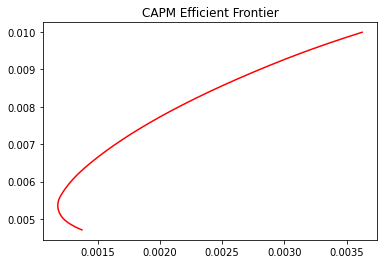

In [27]:
plt.plot(v,k,color="red")
plt.title("CAPM Efficient Frontier")
plt.show()

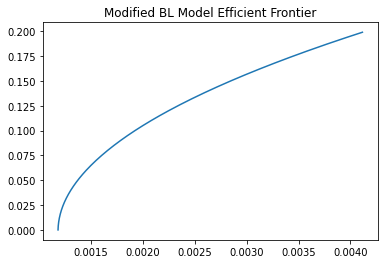

In [28]:
plt.title("Modified BL Model Efficient Frontier")
plt.plot(variance,mean)
plt.show()

In [46]:
s=pd.DataFrame(columns=stock_list)

t=[]
for i in range(20):
    tau=0.025+i*0.025
    t.append(tau)
    m=len(stock_list)
    w = cp.Variable(m)
    l=np.ones(m)
    e=mu_P(w)@w
    BE=beta@w
    var = cp.quad_form(w,0.5*Sigma)
    Rm=0.022423
    objective = cp.Minimize(var)
    constraints = [l@w ==1, w>=0,e-rf-BE*(Rm-rf)==0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    print(w.value)
    s.loc[tau]=w.value
s[[151,417,600030,600036]]=0.0
s

[ 4.00505342e-02 -2.90114984e-20 -4.31537670e-21  8.94426028e-02
  1.02637204e-02 -1.49171591e-20 -3.59304177e-20  8.25006720e-02
  7.24090346e-02  7.05333436e-01]
[ 4.02268481e-02 -2.86708972e-20 -4.38773499e-21  8.71985981e-02
  8.71355683e-03 -1.47817149e-20 -3.62382778e-20  7.56975782e-02
  7.64266006e-02  7.11736818e-01]
[ 4.02439294e-02 -2.85119720e-20 -4.45248725e-21  8.63099289e-02
  8.10047096e-03 -1.47594070e-20 -3.64224314e-20  7.32128276e-02
  7.79683855e-02  7.14164458e-01]
[ 4.02414435e-02 -2.84193830e-20 -4.49898097e-21  8.58285994e-02
  7.77066919e-03 -1.47575224e-20 -3.65413668e-20  7.19027338e-02
  7.87976761e-02  7.15458878e-01]
[ 4.02357467e-02 -2.83602819e-20 -4.53286147e-21  8.55261588e-02
  7.56467505e-03 -1.47588018e-20 -3.66239928e-20  7.10893651e-02
  7.93178574e-02  7.16266197e-01]
[ 4.02299979e-02 -2.83179469e-20 -4.55771975e-21  8.53183840e-02
  7.42383320e-03 -1.47616435e-20 -3.66847659e-20  7.05341006e-02
  7.96751538e-02  7.16818530e-01]
[ 4.02248640e-02

,89,151,417,521,753,600030,600036,600348,600519,601398
0.025,0.040051,0.0,0.0,0.089443,0.010264,0.0,0.0,0.082501,0.072409,0.705333
0.050,0.040227,0.0,0.0,0.087199,0.008714,0.0,0.0,0.075698,0.076427,0.711737
0.075,0.040244,0.0,0.0,0.086310,0.008100,0.0,0.0,0.073213,0.077968,0.714164
0.100,0.040241,0.0,0.0,0.085829,0.007771,0.0,0.0,0.071903,0.078798,0.715459
0.125,0.040236,0.0,0.0,0.085526,0.007565,0.0,0.0,0.071089,0.079318,0.716266
0.150,0.040230,0.0,0.0,0.085318,0.007424,0.0,0.0,0.070534,0.079675,0.716819
0.175,0.040225,0.0,0.0,0.085167,0.007321,0.0,0.0,0.070131,0.079936,0.717220
0.200,0.040220,0.0,0.0,0.085051,0.007244,0.0,0.0,0.069824,0.080135,0.717526
0.225,0.040217,0.0,0.0,0.084960,0.007183,0.0,0.0,0.069583,0.080291,0.717766
0.250,0.040213,0.0,0.0,0.084887,0.007134,0.0,0.0,0.069388,0.080418,0.717960
